# Spam Classifier

In [15]:
# importing the required libraires
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# loading the data
messages = pd.read_csv("spam.csv", encoding='latin-1') #encoding='ISO-8859-1' can also be used
messages.shape

(5572, 5)

In [17]:
# removing unnecessary columns
messages = messages[["v1", "v2"]]
# changing the column names
cnames = ["class", "sms"]
messages.columns = cnames

In [18]:
print(f'Input data has {len(messages)} rows, {len(messages.columns)} columns')

Input data has 5572 rows, 2 columns


Text(0.5, 1.0, 'number of hams and spams')

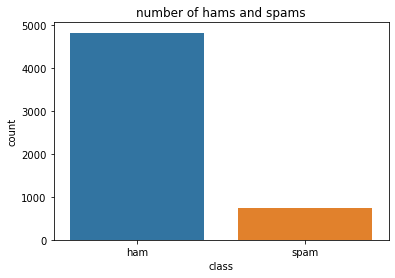

In [19]:
sns.countplot(x = "class", data = messages)
plt.xlabel("class")
plt.title("number of hams and spams")

## Data Cleaning

First goal is to remove all the unnecessary words from the data such as **a**, **the**, **of**, etc because these words are present in large number and don't have any important information. We can use **PorterStemmer** or **Lemmatizer** for that. In this cleaning process we also remove the numbers and lowered all the letters.

In [21]:
#ps = PorterStemmer()
wordnet = WordNetLemmatizer()
corpus = []

for i in range(len(messages)):
    sms = re.sub('[^a-zA-Z]',' ', messages["sms"][i])
    sms = sms.lower()
    sms = sms.split()
    sms = [wordnet.lemmatize(word) for word in sms if not word in set(stopwords.words("english"))]
    sms = ' '.join(sms)
    corpus.append(sms)

Next step is to make the **vectors** from the text becuase our model cannot accept the string, it need some numbers. We can use **CountVectorizer** from **sklearn** or **Tf-Idf**.

In [22]:
cv = CountVectorizer(max_features=5000)
#cv = TfidfVectorizer(max_features=5000)
# creating a bag of words
X = cv.fit_transform(corpus).toarray()

In [138]:
X.shape

(5572, 5000)

Creating a target variable from the data and replace **ham** by **0** and **spam** by **1**.

In [23]:
# getting the target variable
y = messages["class"]
y = y.replace("ham", 0)
y = y.replace("spam", 1)

## Models

Creating train and test data and fitting the **naive bayes classifier** to classify the spam.

In [188]:
# splitting the train test data and training naive bayes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
classifier = MultinomialNB().fit(X_train, y_train)

In [189]:
y_pred = classifier.predict(X_test)

### Evaluation of Naive Bayes Classifier

In the case of binary classification, **confusion matrix** is better way to evaluate the model.

In [190]:
conf_m = confusion_matrix(y_test, y_pred)
print(conf_m)

[[939  10]
 [  8 158]]


In [192]:
accuracy = round(accuracy_score(y_test, y_pred),3)
accuracy

0.984

**Accuracy** of Naive Bayes Classifier is about **98.4%**. 

## Random Forest Classifier

In [204]:
from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators=100,)
classifierRF.fit(X_train, y_train)
y_predRF = classifierRF.predict(X_test)
confusion_matrix(y_test, y_predRF)

array([[948,   1],
       [ 26, 140]], dtype=int64)

In [200]:
#RandomForestClassifier?

In [205]:
round(accuracy_score(y_test, y_predRF),3)

0.976

Accuracy of the **Random Forest Classifier** is **97.6%** which is slightly less than the accuracy of **Naive Bayes Classifier**. We can fine tune the random forest further but naive bayes is working good here. To achieve more accuracy we can use **Recurrent Neural Network**  or **LSTM**.

# LSTM Model

In [38]:
# importing required libraries and layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [34]:
max_words = 5000
one_hot_repr = [one_hot(words,max_words) for words in corpus]
#one_hot_repr

### Embedding

Since the each sentence must have same number of words which is very difficult in real life. To overcome this problem, we use pre-padding for each sentence. It add zeros in each sentence to make all the sentences of the same legth. 

In [51]:
sent_length = 20
embedded_docs = pad_sequences(one_hot_repr, padding = "pre", maxlen = sent_length)
print(embedded_docs[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
 3294 3213 4930  886 1728 2832]


Above sentence have only 6 words but padding added 14 pre-zeros to make it 20.

### Creating a LSTM model

In [42]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(max_words, embedding_vector_features, input_length = sent_length))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'tanh'))
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
# converting data to an array
import numpy as np
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.2, random_state = 0)

In [44]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 64)

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 6s 1ms/sample - loss: 0.2931 - accuracy: 0.9085 - val_loss: 0.1213 - val_accuracy: 0.9570
Epoch 2/10
4457/4457 [==============================] - 3s 604us/sample - loss: 0.0634 - accuracy: 0.9850 - val_loss: 0.0707 - val_accuracy: 0.9803
Epoch 3/10
4457/4457 [==============================] - 3s 713us/sample - loss: 0.0390 - accuracy: 0.9928 - val_loss: 0.0977 - val_accuracy: 0.9803
Epoch 4/10
4457/4457 [==============================] - 3s 725us/sample - loss: 0.0328 - accuracy: 0.9948 - val_loss: 0.0969 - val_accuracy: 0.9803
Epoch 5/10
4457/4457 [==============================] - 3s 723us/sample - loss: 0.0335 - accuracy: 0.9944 - val_loss: 0.0936 - val_accuracy: 0.9839
Epoch 6/10
4457/4457 [==============================] - 3s 735us/sample - loss: 0.0231 - accuracy: 0.9971 - val_loss: 0.0938 - val_accuracy: 0.9821
Epoch 7/10
4457/4457 [==============================] - 4s 786us/s

In [47]:
y_predDL = model.predict_classes(X_test)
confusion_matrix(y_test, y_predDL)

array([[947,   2],
       [ 15, 151]], dtype=int64)

In [48]:
accuracy_score(y_test, y_predDL)

0.9847533632286996

Accuracy of **LSTM** model is **98.5%** which is slightly higher than the **Naive Bayes Classifier** But there is no much improimprovement in the predictions.